# Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                     TimeSeriesSplit, 
                                     cross_val_score
                                    )
from sklearn.metrics import (
                             mean_squared_error, 
                             mean_absolute_error,
                             r2_score
                            )

# entropy
from scipy.stats import entropy

# xgboost
import xgboost as xgb

# salvar modelos
import json
import pickle

In [4]:
#from old.utils import *
from utils import *

# Modelo Baseline

In [5]:
# importar dados
df_baseline = pd.read_parquet(r'data\baseline_data.parquet')

df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9649 entries, 1987-05-20 to 2024-05-13
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            9649 non-null   object 
 1   year             9649 non-null   object 
 2   weekday          9649 non-null   object 
 3   is_weekday       9649 non-null   int32  
 4   is_holiday       9649 non-null   int32  
 5   is_holiday_week  9649 non-null   int32  
 6   sp500            9649 non-null   float64
 7   exxon            9649 non-null   float64
 8   bp               9649 non-null   float64
 9   brent            9649 non-null   float64
 10  brent_diff       9648 non-null   float64
 11  brent_pct        9648 non-null   float64
 12  nasdaq_diff      9648 non-null   float64
 13  nasdaq_pct       9648 non-null   float64
 14  sp500_diff       9648 non-null   float64
 15  sp500_pct        9648 non-null   float64
 16  exxon_diff       9648 non-null   float64
 

In [6]:
# drop diff and pct columns
drop_cols = [col for col in df_baseline.columns if 'diff' in col or 'pct' in col]

df_baseline.drop(columns=drop_cols, inplace=True)

In [7]:
# one hot encoding
df_baseline = pd.get_dummies(df_baseline, 
                             columns=['month', 'year', 'weekday'],
                             drop_first=True)

df_baseline.columns = [str.lower(s) for s in df_baseline.columns]

print(df_baseline.columns.tolist())

df_baseline.shape

['is_weekday', 'is_holiday', 'is_holiday_week', 'sp500', 'exxon', 'bp', 'brent', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september', 'year_1988', 'year_1989', 'year_1990', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996', 'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'weekday_monday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday']


(9649, 59)

In [8]:
X = df_baseline.drop(columns=['brent'])
y = df_baseline['brent']

# train test split - simple
train_baseline_size = int(df_baseline.shape[0] * 0.8)

# 80/20
X_train_baseline, X_test_baseline = X[:train_baseline_size], X[train_baseline_size:]
y_train_baseline, y_test_baseline = y[:train_baseline_size], y[train_baseline_size:]

# shape
X_train_baseline.shape, X_test_baseline.shape, y_train_baseline.shape, y_test_baseline.shape

((7719, 58), (1930, 58), (7719,), (1930,))

In [9]:
# plotar treino e teste no mesmo gráfico com plotly
plotly_df = pd.DataFrame({'date': df_baseline.index,
                          'brent': df_baseline['brent']})
plotly_df['set'] = 'train'
plotly_df.loc[X_test_baseline.index, 'set'] = 'test'

# export plotly_df as xgboost_baseline_train_test
plotly_df.to_parquet(r'data\xgboost_baseline_train_test.parquet')

fig = px.line(plotly_df, x='date', y='brent', 
              title='XGBoost Baseline - Treino e Teste', 
              color='set', 
              color_discrete_map={'train': '#4089FF', 
                                  'test': '#f6c409'},
              template='plotly_dark')

# y_lim = max(y)+10% para melhor visualização
fig.update_yaxes(range=[min(y), max(y)+max(y)*0.1])
# linha tracejada vertical para dividir treino e teste
fig.add_shape(type='line', 
                x0=X_test_baseline.index[0],
                y0=0,
                x1=X_test_baseline.index[0],
                y1=max(y)+max(y)*0.1,
               line=dict(color='white', width=1, dash='dash'))

fig.show()

`XGBoost` stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. - https://xgboost.readthedocs.io/en/stable/tutorials/model.html

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) xi to predict a target variable yi.



In [10]:
# baseline xgboost regressor
xgb_baseline = xgb.XGBRegressor(n_estimators=1000,               # número de árvores
                                max_depth=3,                     # profundidade máxima = 3 níveis
                                booster='gbtree',                # default
                                early_stopping_rounds=50,        # para após 50 iterações sem melhorar
                                objective='reg:squarederror' ,   # função objetivo = erro quadrático
                                learning_rate=0.01,              # taxa de aprendizado menor para prevenir overfitting
                                random_state=19)                 # para reprodução 

xgb_baseline.fit(X_train_baseline, y_train_baseline,
                eval_set=[(X_train_baseline, y_train_baseline),  # avaliação no treino
                          (X_test_baseline, y_test_baseline)],   # avaliação no teste
                verbose=True)

[0]	validation_0-rmse:33.50199	validation_1-rmse:31.64522
[1]	validation_0-rmse:33.21280	validation_1-rmse:31.48939
[2]	validation_0-rmse:32.92684	validation_1-rmse:31.33725
[3]	validation_0-rmse:32.64418	validation_1-rmse:31.18880
[4]	validation_0-rmse:32.36470	validation_1-rmse:31.04394
[5]	validation_0-rmse:32.08841	validation_1-rmse:30.90265
[6]	validation_0-rmse:31.81510	validation_1-rmse:30.76561
[7]	validation_0-rmse:31.54492	validation_1-rmse:30.63130
[8]	validation_0-rmse:31.27806	validation_1-rmse:30.50053
[9]	validation_0-rmse:31.01396	validation_1-rmse:30.37305
[10]	validation_0-rmse:30.75299	validation_1-rmse:30.24946
[11]	validation_0-rmse:30.48656	validation_1-rmse:30.22731
[12]	validation_0-rmse:30.22315	validation_1-rmse:30.20551
[13]	validation_0-rmse:29.97088	validation_1-rmse:30.08754
[14]	validation_0-rmse:29.71317	validation_1-rmse:30.06752
[15]	validation_0-rmse:29.45838	validation_1-rmse:30.04782
[16]	validation_0-rmse:29.21412	validation_1-rmse:29.93699
[17]	va

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=19, ...)

In [11]:
# importância com plotly
importance_df = pd.DataFrame({'feature': X_train_baseline.columns,
                              'importance': xgb_baseline.feature_importances_})

importance_df = importance_df.sort_values(by='importance', ascending=True)

# 10 mais importantes
importance_df = importance_df[-10:]
# exportar importance_df como xgboost_baseline_importance
importance_df.to_parquet(r'data\xgboost_baseline_importance.parquet')

# horizontal bar plot
fig = px.bar(importance_df, x='importance', y='feature',
                title='Importância das Features - XGBoost Baseline',
                template='plotly_dark',
                labels={'importance': 'Importância', 'feature': 'Feature'})

fig.show()

Exxon Mobil é a feature mais importante no modelo baseline para prever o preço do petróleo Brent.

In [12]:
# predição em test set
X_test_baseline['prediction'] = xgb_baseline.predict(X_test_baseline)

df_baseline['prediction'] = X_test_baseline['prediction']

# plotar treino e teste no mesmo gráfico com plotly
plotly_df = pd.DataFrame({'date': df_baseline.index,
                          'brent': df_baseline['brent'],
                          'prediction': df_baseline['prediction']})
# export plotly_df as xgboost_baseline_prediction
plotly_df.to_parquet(r'data\xgboost_baseline_prediction.parquet')

fig = px.line(plotly_df, x='date', y=['brent', 'prediction'],
                title='XGBoost Baseline - Predição vs Real', 
                color_discrete_map={'brent': '#4089FF', 
                                    'prediction': '#e34592'},
                labels={'variable': 'variável', 'value': 'preço (USD)'},
                template='plotly_dark')
                

fig.show()

In [13]:
# métricas MSE, RMSE, MAE, MAPE, R2
scores_df = pd.DataFrame({
                          'model': ['XGBoost Baseline'],
                          'RMSE': [np.sqrt(mean_squared_error(y_test_baseline, X_test_baseline['prediction']))],
                          'MAE': [mean_absolute_error(y_test_baseline, X_test_baseline['prediction'])],
                          'MAPE': [mape(y_test_baseline, X_test_baseline['prediction'])],
                        })

# exportar
scores_df.to_parquet(r'data\xgboost_baseline_scores.parquet')

scores_df

,model,RMSE,MAE,MAPE
0,XGBoost Baseline,23.521241,17.100133,22.967917


In [14]:
# salvar baseline
with open(r'models\xgb_baseline.json', 'w') as file:
    json.dump(xgb_baseline.get_params(), file)
    
# salvar modelo
with open(r'models\xgb_baseline.pkl', 'wb') as file:
    pickle.dump(xgb_baseline, file)

# Melhor Modelo

In [15]:
# grid search
from sklearn.model_selection import GridSearchCV

In [16]:
df = pd.read_parquet(r'data\data_w_indicators.parquet')

# drop null
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9450 entries, 1988-02-23 to 2024-05-13
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              9450 non-null   object 
 1   year               9450 non-null   object 
 2   weekday            9450 non-null   object 
 3   is_weekday         9450 non-null   int32  
 4   is_holiday         9450 non-null   int32  
 5   is_holiday_week    9450 non-null   int32  
 6   sp500              9450 non-null   float64
 7   exxon              9450 non-null   float64
 8   bp                 9450 non-null   float64
 9   brent              9450 non-null   float64
 10  brent_diff         9450 non-null   float64
 11  brent_pct          9450 non-null   float64
 12  nasdaq_diff        9450 non-null   float64
 13  nasdaq_pct         9450 non-null   float64
 14  sp500_diff         9450 non-null   float64
 15  sp500_pct          9450 non-null   float64
 16  exxon_

In [17]:
# drop brent_ema columns
ema_cols = [col for col in df.columns if 'brent_ema' in col]

df = df.drop(columns=ema_cols)

In [18]:
# manter apenas brent_diff como parâmetro diferencial
#drop_cols = drop_cols[1:]

df = df.drop(columns=drop_cols)

In [19]:
# mapear lags
lags = [1, 5, 20]

df = map_lag(df, 'brent', lags)

df

,month,year,weekday,is_weekday,is_holiday,is_holiday_week,sp500,exxon,bp,brent,brent_rsi,brent_macd,brent_macd_signal,brent_macd_hist,lag_1,lag_5,lag_20
date,,,,,,,,,,,,,,,,,
1988-02-23,February,1988,Tuesday,1,0,0,265.019989,10.718750,13.718750,15.58,40.291494,-0.304675,-0.272856,-0.031820,NaN,NaN,NaN
1988-02-24,February,1988,Wednesday,1,0,0,264.429993,10.562500,13.500000,15.35,37.018447,-0.314955,-0.281276,-0.033679,15.58,NaN,NaN
1988-02-25,February,1988,Thursday,1,0,0,261.579987,10.406250,13.656250,14.85,31.103223,-0.359305,-0.296882,-0.062424,15.35,NaN,NaN
1988-02-26,February,1988,Friday,1,0,0,262.459991,10.312500,13.593750,14.65,29.100167,-0.405913,-0.318688,-0.087225,14.85,NaN,NaN
1988-02-29,February,1988,Monday,1,0,0,267.820007,10.656250,13.281250,14.73,31.013954,-0.431421,-0.341234,-0.090186,NaN,15.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07,May,2024,Tuesday,1,0,0,5187.700195,116.169998,37.580002,82.69,35.495504,-1.218507,-0.338899,-0.879608,82.69,84.81,89.54
2024-05-08,May,2024,Wednesday,1,0,0,5187.669922,116.150002,37.529999,82.44,34.908648,-1.393547,-0.549829,-0.843718,82.69,83.60,88.34
2024-05-09,May,2024,Thursday,1,0,0,5214.080078,118.440002,38.040001,83.27,38.541620,-1.448595,-0.729582,-0.719013,82.44,NaN,87.96


In [20]:
# one hot encoding
df = pd.get_dummies(df, 
                    columns=['month', 'year', 'weekday'],
                    drop_first=True)

df.columns = [str.lower(s) for s in df.columns]

print(f'Features: {df.columns.tolist()}')

df.shape

Features: ['is_weekday', 'is_holiday', 'is_holiday_week', 'sp500', 'exxon', 'bp', 'brent', 'brent_rsi', 'brent_macd', 'brent_macd_signal', 'brent_macd_hist', 'lag_1', 'lag_5', 'lag_20', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september', 'year_1989', 'year_1990', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996', 'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'weekday_monday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday']


(9450, 65)

In [21]:
X = df.drop(columns=['brent'])
y = df['brent']

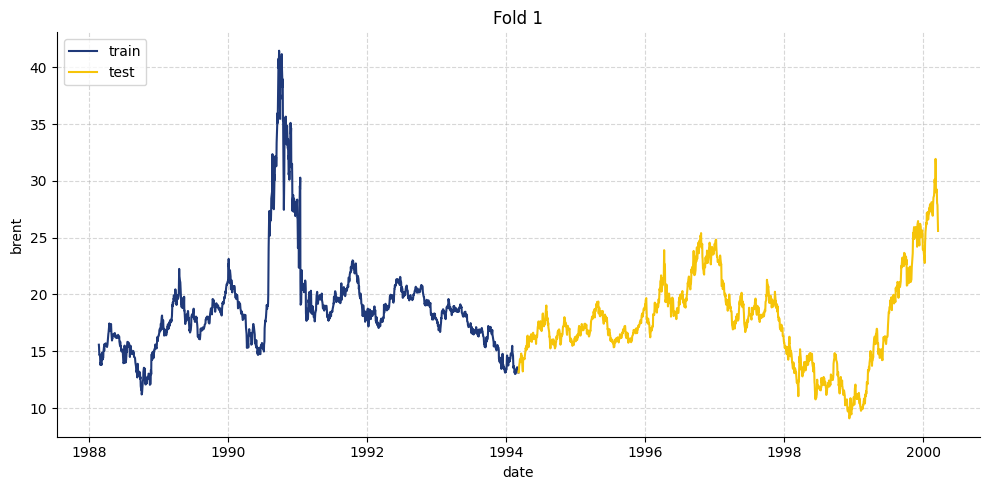

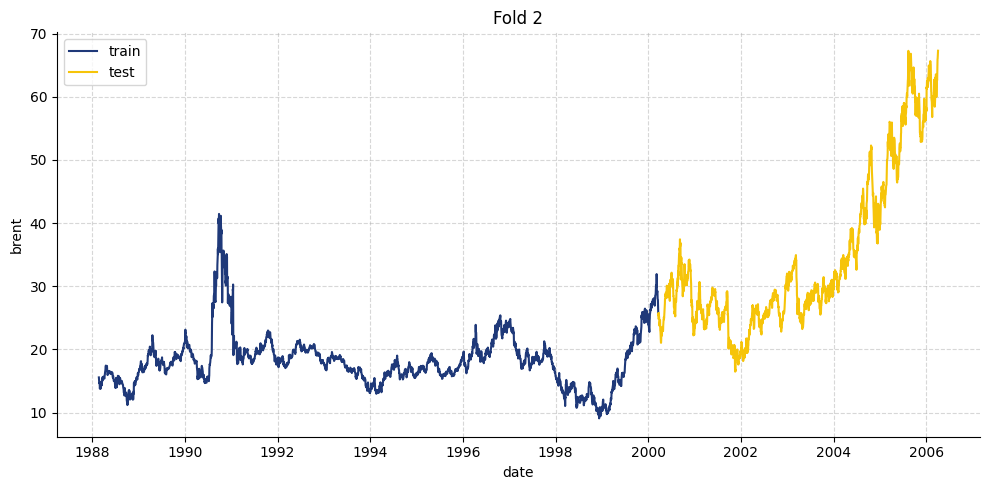

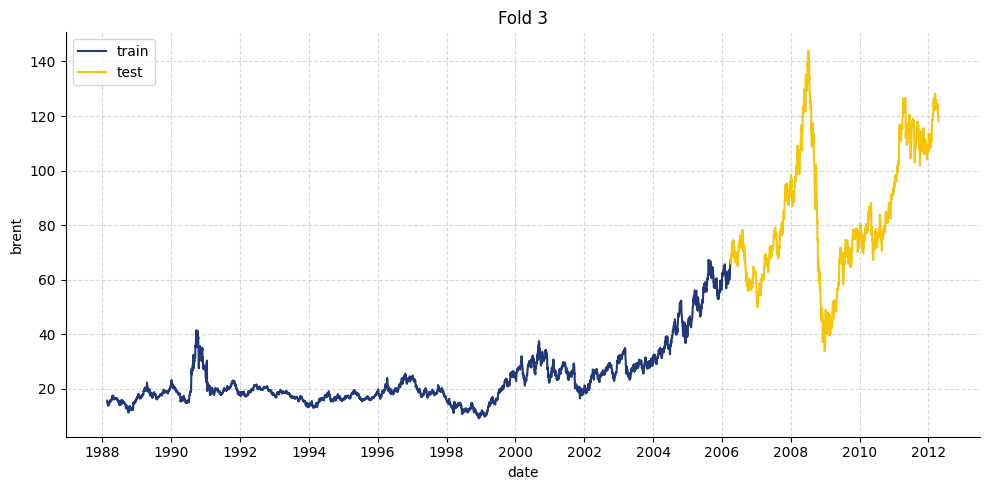

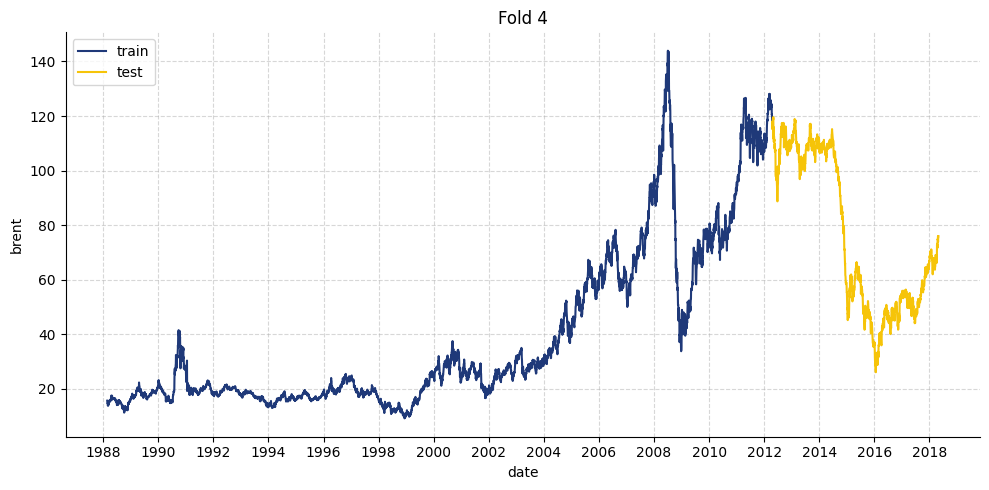

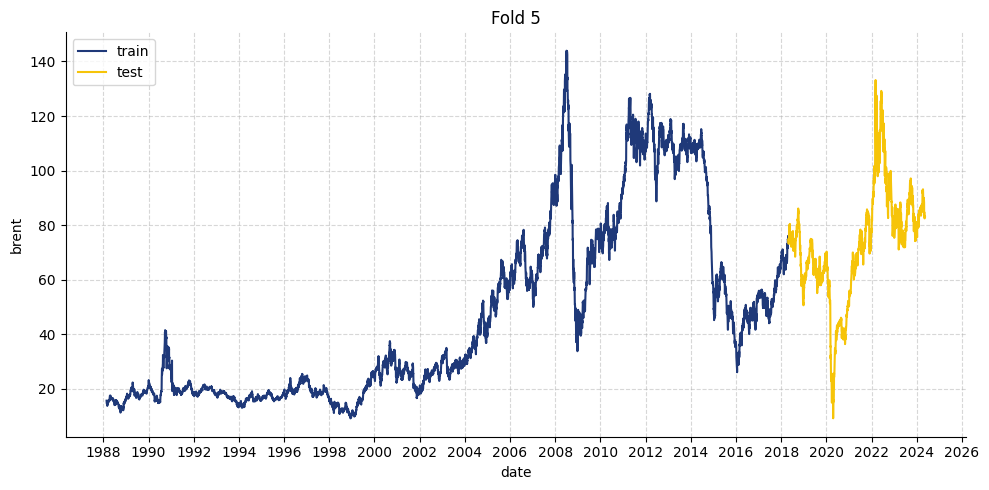

In [22]:
X = df.drop(columns=['brent'])
y = df['brent']

# train test split - tscv
tscv = TimeSeriesSplit(n_splits=5)

i = 1
# split train, tes
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # plotar com seaborn
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=X_train.index, y=y_train, label='train', color='#1f3979')
    sns.lineplot(x=X_test.index, y=y_test, label='test', color='#f6c409')
    plt.legend(loc='upper left')
    plt.title(f'Fold {i}')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()
    i += 1

In [23]:
# X as array
X = np.array(X)
y = np.array(y)

# dim
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# grid search
param_grid = {
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1]
}

booster='gblinear'
objective = 'reg:squarederror'
random_state = 19

xgb_model = xgb.XGBRegressor(objective=objective,
                             booster=booster,
                             random_state=random_state) 

grid_search = GridSearchCV(estimator=xgb_model,
                            param_grid=param_grid,
                            cv=tscv,
                            scoring='neg_mean_squared_error',
                            verbose=2,
                            n_jobs=-1)

grid_search.fit(X, y)

# best params
best_params = grid_search.best_params_
# estimator
best_estimator = grid_search.best_estimator_
# best score
best_score = grid_search.best_score_

best_params, best_estimator, best_score

X shape: (9450, 64)
y shape: (9450,)
Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000},
 XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=19, ...),
 -404.1183669918027)

In [24]:
# make cv_results into a dataframe
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.sort_values(by='rank_test_score')
# salvar cv_results_df
cv_results_df.to_parquet(r'data\xgboost_grid_search_results.parquet')
# head
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
42,1.984822,1.038101,0.008662,0.001973,0.1,7,1000,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",-45.225049,-58.478653,-1252.248013,-509.765203,-154.874918,-404.118367,456.262791,1
38,1.988553,0.894136,0.008260,0.001201,0.1,5,1000,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-45.225049,-58.478653,-1252.248013,-509.765203,-154.874918,-404.118367,456.262791,1
34,2.503238,1.442398,0.009957,0.001784,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-45.225049,-58.478653,-1252.248013,-509.765203,-154.874918,-404.118367,456.262791,1
46,1.690220,0.711912,0.008458,0.003414,0.1,9,1000,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",-45.225049,-58.478653,-1252.248013,-509.765203,-154.874918,-404.118367,456.262791,1
47,2.297289,0.783101,0.006619,0.002247,0.1,9,2000,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",-50.500043,-55.241465,-1256.123202,-521.185741,-188.166056,-414.243301,454.422898,5


In [25]:
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

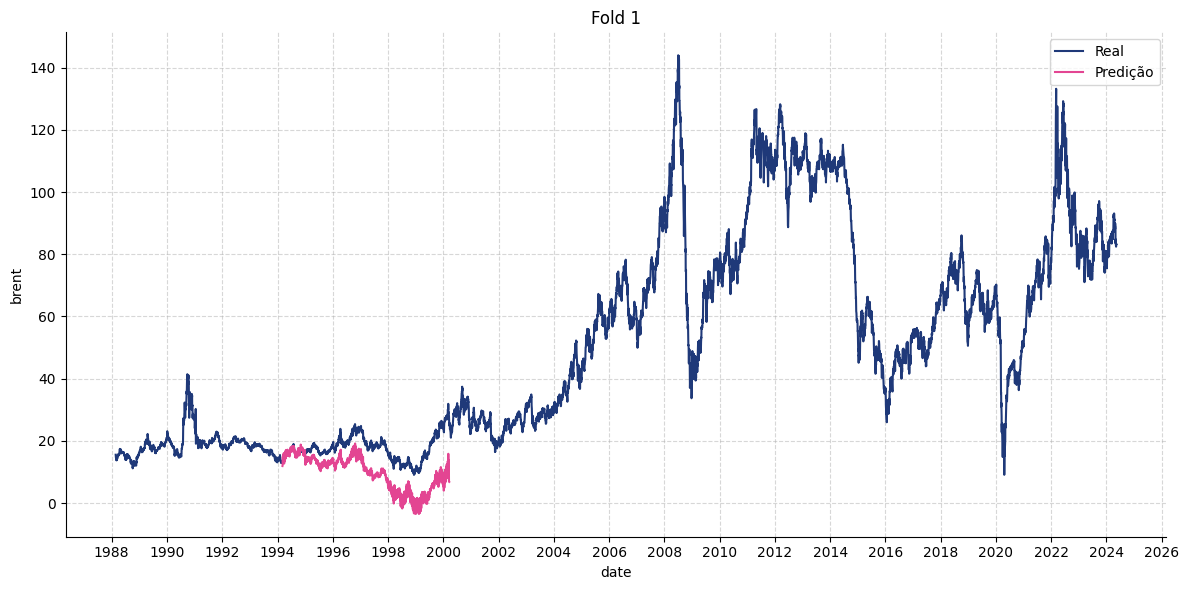

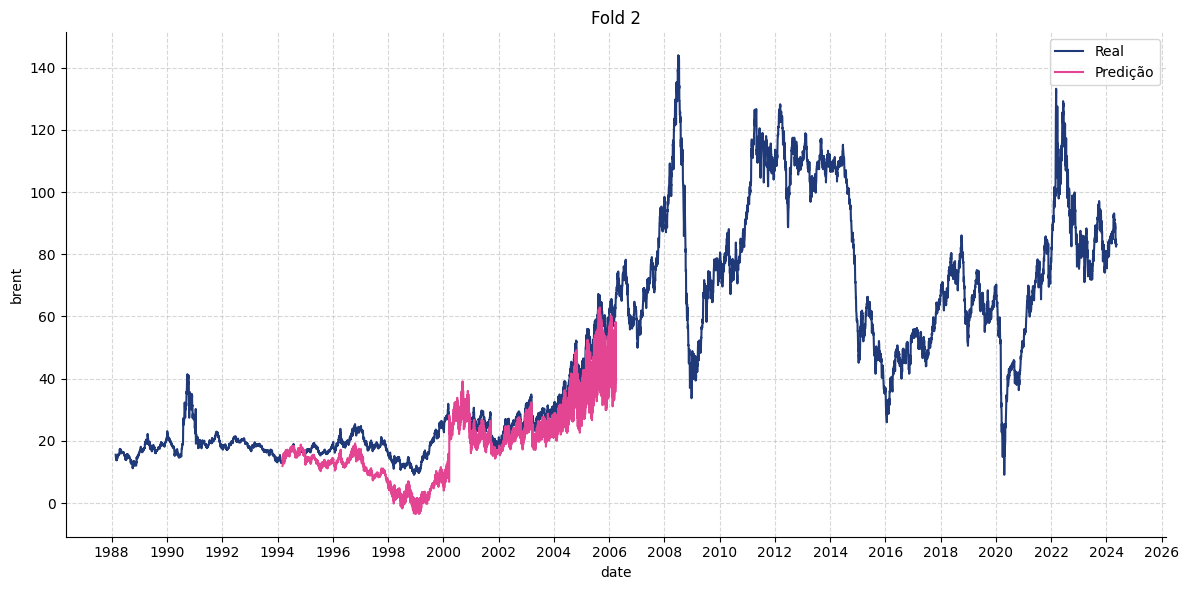

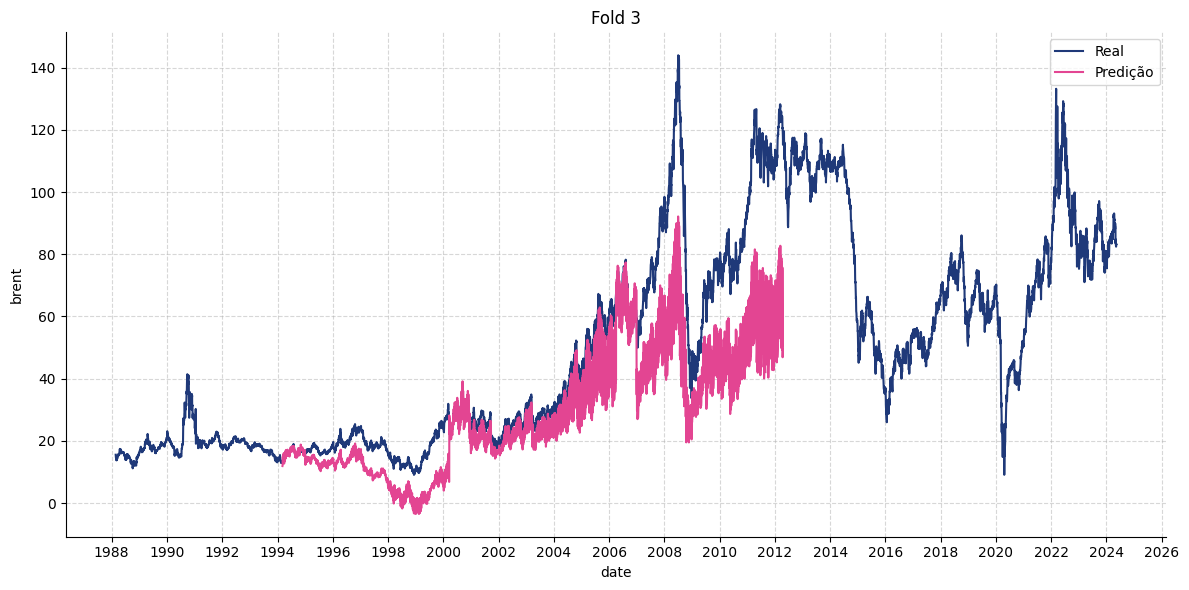

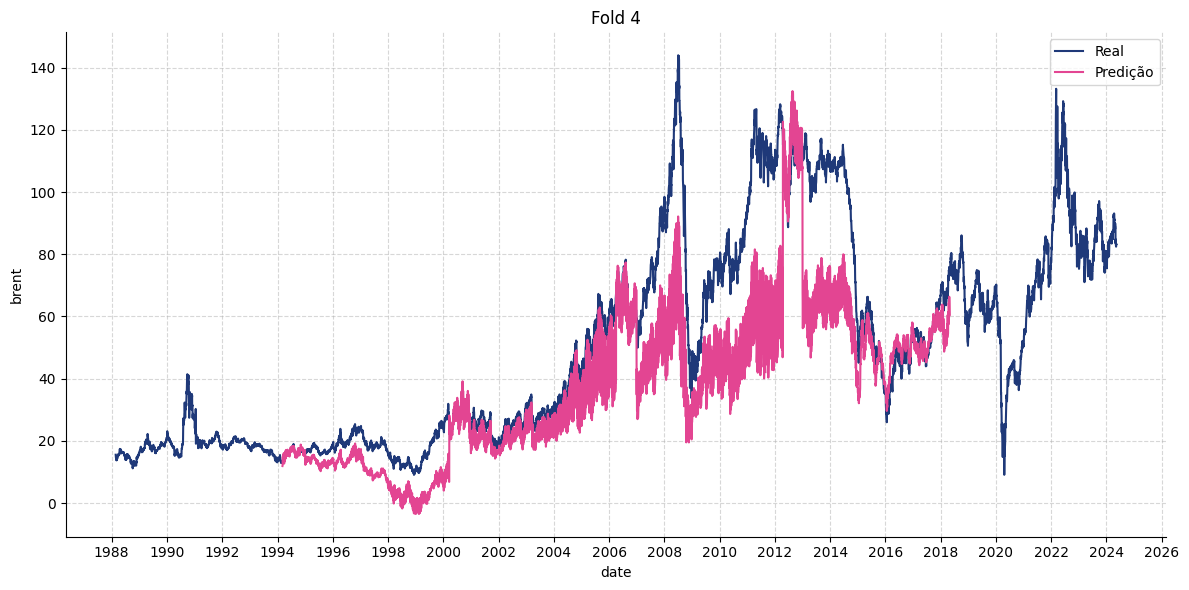

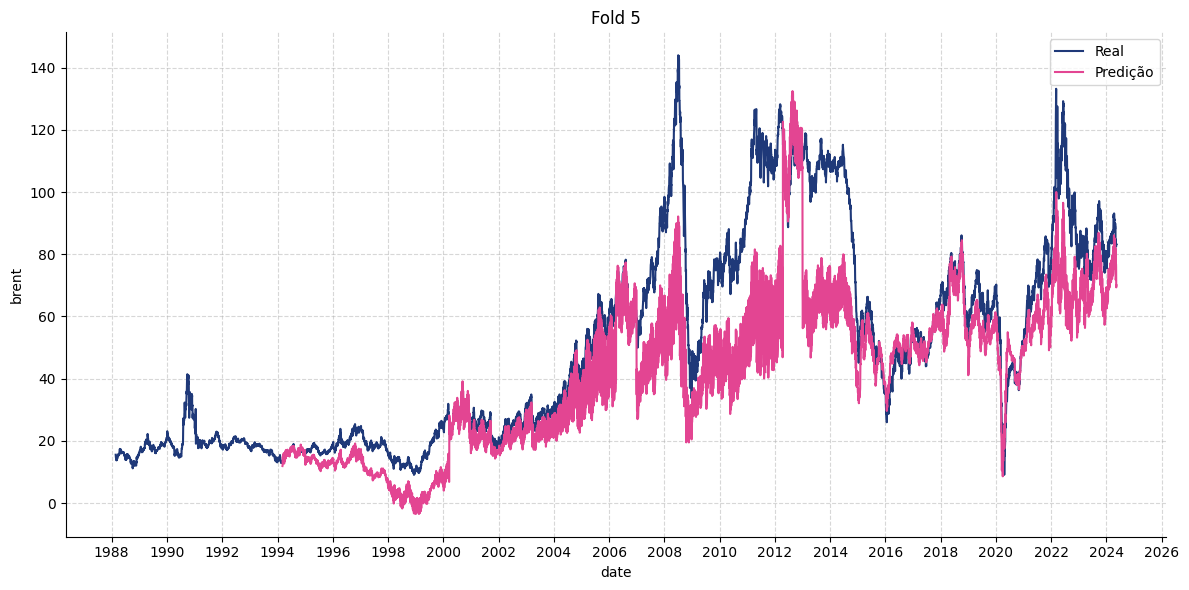

,model,RMSE,MAE,MAPE
0,XGBoost Baseline,23.521241,17.100133,22.967917
1,XGBoost Best1,9.251322,7.916051,46.749444
2,XGBoost Best2,8.690075,6.419775,17.300710
3,XGBoost Best3,36.732338,31.942626,36.127006
4,XGBoost Best4,24.157312,16.753822,18.576218
5,XGBoost Best5,15.897873,12.316202,16.061028


In [26]:
# make model with best params
xgb_best = xgb.XGBRegressor(**best_params,
                            objective=objective,
                            booster=booster,
                            random_state=random_state)

i = 1
# fit with cross validation X_train and y_train, X_test and y_test
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit
    xgb_best.fit(X_train, y_train,
                eval_set=[(X_train, y_train),  # avaliação no treino
                          (X_test, y_test)],   # avaliação no teste
                verbose=False)
    
    # predict
    y_pred = xgb_best.predict(X_test)
    # prediction to df
    df.loc[df.index[test_index], 'prediction'] = y_pred
    # fold to df
    df.loc[df.index[test_index], 'fold'] = i
    
    # erro médio de todas as dobras para scores_df
    best_model_scores = {
        'model': f'XGBoost Best{i}',
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mape(y_test, y_pred),
    }

    scores_df = scores_df.merge(pd.DataFrame(best_model_scores, index=[0]),
                                how='outer')
    
    # plotar cada fold com seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='brent', data=df, 
                 label='Real', color='#1f3979')
    sns.lineplot(x='date', y='prediction', data=df, 
                 label='Predição', color='#e34592')
    plt.title(f'Fold {i}')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()
    i += 1

scores_df

In [27]:
# prever apenas 20% finais dos dados
predict_size = int(df.shape[0] * 0.2)

predict_df = df.iloc[-predict_size:].copy()

# rop
predict_df = predict_df.drop(columns=['brent', 'prediction', 'fold'])

predict_df['prediction'] = xgb_best.predict(predict_df)

# plotar todas as datas de df e as datas de predict_df
plotly_df = pd.DataFrame({'date': df.index,
                          'brent': df['brent'],
                          'prediction': predict_df['prediction']})

# exportar plotly_df como xgboost_best_prediction
plotly_df.to_parquet(r'data\xgboost_best_prediction.parquet')

fig = px.line(plotly_df, x='date', y=['brent', 'prediction'],
                title='XGBoost Best - Predição vs Real', 
                color_discrete_map={'brent': '#4089FF', 
                                    'prediction': '#e34592'},
                labels={'variable': 'variável', 'value': 'preço (USD)'},
                template='plotly_dark')

fig.show()

In [28]:
# avaliar predição
y_pred = predict_df['prediction']
y_test = df['brent'][-predict_size:]

# scores
best_model_scores = {
    'model': 'XGBoost Best',
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mape(y_test, y_pred),
}

scores_df = scores_df.merge(pd.DataFrame(best_model_scores, index=[0]),
                            how='outer')

# exportar scores_df
scores_df.to_parquet(r'data\xgboost_best_scores.parquet')

scores_df

,model,RMSE,MAE,MAPE
0,XGBoost Baseline,23.521241,17.100133,22.967917
1,XGBoost Best,14.563733,10.685401,14.125974
2,XGBoost Best1,9.251322,7.916051,46.749444
3,XGBoost Best2,8.690075,6.419775,17.300710
4,XGBoost Best3,36.732338,31.942626,36.127006
5,XGBoost Best4,24.157312,16.753822,18.576218
6,XGBoost Best5,15.897873,12.316202,16.061028


In [29]:
# feature importance
X = df.drop(columns=['brent', 'prediction', 'fold'])

importance_df = pd.DataFrame({'feature': X.columns,
                              'importance': xgb_best.feature_importances_})

importance_df = importance_df.sort_values(by='importance', ascending=True)

# 10 mais importantes
importance_df = importance_df[-10:]

# salvar df
importance_df.to_parquet(r'data\xgboost_best_importance.parquet')

# horizontal bar plot
fig = px.bar(importance_df, x='importance', y='feature',
                title='Importância das Features - XGBoost',
                template='plotly_dark',
                labels={'importance': 'Importância', 'feature': 'Feature'})

fig.show()

In [31]:
# comparar com o modelo baseline
rmse_baseline = np.sqrt(mean_squared_error(y_test_baseline, X_test_baseline['prediction']))
mae_baseline = mean_absolute_error(y_test_baseline, X_test_baseline['prediction'])
mape_baseline = mape(y_test_baseline, X_test_baseline['prediction'])

rmse_best = np.sqrt(mean_squared_error(y_test, predict_df['prediction']))
mae_best = mean_absolute_error(y_test, predict_df['prediction'])
mape_best = mape(y_test, predict_df['prediction'])

# percentual de melhoria
rmse_improvement = (rmse_baseline - rmse_best) / rmse_baseline * 100
mae_improvement = (mae_baseline - mae_best) / mae_baseline * 100
mape_improvement = (mape_baseline - mape_best) / mape_baseline * 100

print(f'RMSE Improvement: {rmse_improvement:.2f}%')
print(f'MAE Improvement: {mae_improvement:.2f}%')
print(f'MAPE Improvement: {mape_improvement:.2f}%')

RMSE Improvement: 38.08%
MAE Improvement: 37.51%
MAPE Improvement: 38.50%


In [32]:
# salvar modelo
with open('models/xgb_final_model.json', 'w') as file:
    file.write(json.dumps(best_params))

# salvar modelo
with open('models/xgb_final_model.pkl', 'wb') as file:
    pickle.dump(xgb_best, file)